<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/notebooks/tune_hyper_parameters_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.14.0
from google.colab import drive

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd /content/gdrive/MyDrive/concept_learning/concept_learning

/content/gdrive/MyDrive/concept_learning/concept_learning


# Plot model_complexity Vs training and validation loss

In [4]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from clearn.config import ExperimentConfig
from clearn.analysis.plot_metrics import plot_z_dim_vs_accuracy, plot_epoch_vs_metric

# Experiment Parameters

In [10]:
create_split = False
experiment_name = "Experiment_2"
num_val_samples = -1
split_name ="Split_70_30"
reconstruction_weight = 0
dataset_name="mnist"
batch_size=128
z_dim_range = [5, 30, 2]

num_epochs = 10
num_cluster_config = ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW
manual_labels_config = ExperimentConfig.USE_CLUSTER_CENTER,
root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"
run_id = 1

In [11]:
from typing import List
from clearn.dao.dao_factory import get_dao
from clearn.analysis.plot_metrics import read_accuracy_from_file
def plot_epoch_vs_accuracy(root_path: str,
                           experiment_name: str,
                           num_units: List[int],
                           num_cluster_config: str,
                           z_dim: int,
                           run_id: int,
                           dataset_types: List[str] = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name="mnist",
                           split_name="Split_1",
                           batch_size=64,
                           num_val_samples=128,
                           num_decoder_layer=4
                           ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    exp_config = ExperimentConfig(root_path=root_path,
                                  num_decoder_layer=num_decoder_layer,
                                  z_dim=z_dim,
                                  num_units=num_units,
                                  num_cluster_config=num_cluster_config,
                                  confidence_decay_factor=5,
                                  beta=5,
                                  supervise_weight=1,
                                  dataset_name=dataset_name,
                                  split_name=split_name,
                                  model_name="VAE",
                                  batch_size=batch_size,
                                  name=experiment_name,
                                  num_val_samples=num_val_samples,
                                  total_training_samples=dao.number_of_training_samples,
                                  manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                  reconstruction_weight=1,
                                  activation_hidden_layer="RELU",
                                  activation_output_layer=activation_output_layer
                                  )
    exp_config.check_and_create_directories(run_id)

    file_prefix = "/accuracy_*.csv"
    df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
    print(df.shape)
    for dataset_name in dataset_types:
        print(dataset_name)
        plt.plot(df["epoch"], df[f"{dataset_name}_accuracy"], label=f"{dataset_name}_z_dim_{z_dim}")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.title(f"Number of units {num_units}")
    plt.grid()

In [12]:
from typing import List
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from clearn.config import ExperimentConfig
from clearn.dao.dao_factory import get_dao
from clearn.utils.dir_utils import get_eval_result_dir


def plot_z_dim_vs_accuracy(root_path: str,
                           experiment_name: str,
                           z_dim_range: List,
                           num_units: List,
                           num_cluster_config: str,
                           num_epochs: int,
                           run_id: int,
                           split_name: str,
                           num_val_samples: int,
                           activation_output_layer="SIGMOID",
                           dataset_name="mnist",
                           batch_size=64,
                           num_decoder_layer=4
                           ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    training_accuracies = []
    z_dims = []
    validation_accuracies = []
    for z_dim in range(z_dim_range[0], z_dim_range[1], z_dim_range[2]):
        exp_config = ExperimentConfig(root_path=root_path,
                                      num_decoder_layer=num_decoder_layer,
                                      z_dim=z_dim,
                                      num_units=num_units,
                                      num_cluster_config=num_cluster_config,
                                      confidence_decay_factor=5,
                                      beta=5,
                                      supervise_weight=1,
                                      dataset_name=dataset_name,
                                      split_name=split_name,
                                      model_name="VAE",
                                      batch_size=batch_size,
                                      name=experiment_name,
                                      num_val_samples=num_val_samples,
                                      total_training_samples=dao.number_of_training_samples,
                                      manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                      reconstruction_weight=1,
                                      activation_hidden_layer="RELU",
                                      activation_output_layer=activation_output_layer
                                      )
        exp_config.check_and_create_directories(run_id, False)
        file_prefix = "/train_accuracy_*.csv"
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        if df is not None:
          _train_accuracies = df["accuracy"].values
        else:
          # Try older version of accuracy file
          file_prefix = "/accuracy_*.csv"
          df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
          if df is not None:
            _train_accuracies = df["train_accuracy"].values
            _val_accuracies = df["val_accuracy"].values
          else:
            raise Exception(f"File does not exist {exp_config.ANALYSIS_PATH + file_prefix}")
        max_accuracy = np.max(_train_accuracies)
        max_index = np.argmax(_train_accuracies)
        training_accuracies.append(max_accuracy)

        exp_config.check_and_create_directories(run_id)

        file_prefix = "/val_accuracy_*.csv"
        
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        if df is not None:
          _val_accuracies = df["accuracy"].values
        else:
          # Try older version of accuracy file
          file_prefix = "/accuracy_*.csv"
          df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
          if df is not None:
            _val_accuracies = df["val_accuracy"].values
          else:
            raise Exception(f"File does not exist {exp_config.ANALYSIS_PATH + file_prefix}")
        max_accuracy = np.max(_val_accuracies)
        max_index = np.argmax(_val_accuracies)
        validation_accuracies.append(max_accuracy)

        z_dims.append(z_dim)

    plt.plot(z_dims, training_accuracies)
    plt.plot(z_dims, validation_accuracies)
    plt.legend(["train", "Validation"])
    plt.xlabel("z_dim")
    plt.ylabel("Accuracy")
    plt.title(f"Num units {num_units} Training epochs {num_epochs}")


def read_accuracy_from_file(file_prefix):
    df = None
    print(file_prefix)
    for file in glob.glob(file_prefix):
        print(file_prefix, file)
        temp_df = pd.read_csv(file)
        if df is None:
            df = temp_df
        else:
            pd.concat([df, temp_df], axis=1)
    return df


def plot_epoch_vs_metric(root_path: str,
                         experiment_name: str,
                         num_units: List[int],
                         num_cluster_config: str,
                         z_dim: int,
                         run_id: int,
                         dataset_types: List[str]=["train", "test"],
                         activation_output_layer="SIGMOID",
                         dataset_name="mnist",
                         split_name="Split_1",
                         batch_size=64,
                         num_val_samples=128,
                         num_decoder_layer=4,
                         metrics: List[str]=["accuracy"],
                         legend_loc="best",
                         show_sample_images=True
                         ):
    colors = ['r', 'g', 'b', 'y']
    dao = get_dao(dataset_name, split_name, num_val_samples)
    exp_config = ExperimentConfig(root_path=root_path,
                                  num_decoder_layer=num_decoder_layer,
                                  z_dim=z_dim,
                                  num_units=num_units,
                                  num_cluster_config=num_cluster_config,
                                  confidence_decay_factor=5,
                                  beta=5,
                                  supervise_weight=1,
                                  dataset_name=dataset_name,
                                  split_name=split_name,
                                  model_name="VAE",
                                  batch_size=batch_size,
                                  name=experiment_name,
                                  num_val_samples=num_val_samples,
                                  total_training_samples=dao.number_of_training_samples,
                                  manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                  reconstruction_weight=1,
                                  activation_hidden_layer="RELU",
                                  activation_output_layer=activation_output_layer
                                  )
    exp_config.check_and_create_directories(run_id, False)
    file_prefix = "/metrics_*.csv"
    df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
    ax = [None] * len(metrics)
    plots = [None] * (len(metrics) * len(dataset_types))
    plot_number = 0
    fig = plt.figure(figsize=[20,10])
    for i, metric in enumerate(metrics):
        if i == 0:
            main_axis = plt.subplot(1, 2, 1)
            ax[i] = main_axis
        else:
            ax[i] = main_axis.twinx()

        for dataset_type in dataset_types:
            plots[plot_number], = ax[i].plot(df["epoch"],
                                             df[f"{dataset_type}_{metric}"],
                                             colors[plot_number],
                                             label=f"{dataset_type}_{metric}")
            plot_number += 1
        plt.ylabel(metric.title())
        plt.xlabel("Epochs")
    if show_sample_images:
      im_ax = plt.subplot(1,2,2)
      _num_epochs_trained = df["epoch"].max()
      _num_batches_train = dao.number_of_training_samples // exp_config.BATCH_SIZE

      reconstructed_dir = get_eval_result_dir(exp_config.PREDICTION_RESULTS_PATH,
                                              _num_epochs_trained,
                                              _num_batches_train)
      print(reconstructed_dir)
      sample_image = cv2.imread(reconstructed_dir + "/im_0.png")
      im_ax.imshow( sample_image )

    main_axis.legend(handles=plots,
                     labels=[l.get_label() for l in plots],
                     loc=legend_loc,
                     shadow=True,
                     fontsize='x-large')
    plt.suptitle(f"Number of units {num_units} z_dim = {z_dim}")
    plt.grid()


def plot_hidden_units_accuracy_layerwise(root_path: str,
                                         experiment_name: str,
                                         num_units: List[List[int]],
                                         num_cluster_config: str,
                                         z_dim: int,
                                         run_id: int,
                                         dataset_types: List[str] = ["train", "test"],
                                         activation_output_layer="SIGMOID",
                                         dataset_name="mnist",
                                         split_name="Split_1",
                                         batch_size=64,
                                         num_val_samples=128,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[]
                                         ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    for dataset_name in dataset_types:
        plt.figure()

        plt.xlabel("Hidden Units")
        plt.ylabel(f"Max Accuracy({dataset_name})")
        accuracies = dict()
        num_epochs_trained = -1
        for num_unit in num_units:
            if len(fixed_layers) > 0:
                skip_this = False
                for index, fixed_layer in enumerate(fixed_layers):
                    if num_unit[index] != fixed_layer:
                        skip_this = True
                        break
                if skip_this:
                    print(f"Skipping num_units {num_unit}")
                    continue

            exp_config = ExperimentConfig(root_path=root_path,
                                          num_decoder_layer=num_decoder_layer,
                                          z_dim=z_dim,
                                          num_units=num_unit,
                                          num_cluster_config=num_cluster_config,
                                          confidence_decay_factor=5,
                                          beta=5,
                                          supervise_weight=1,
                                          dataset_name=dataset_name,
                                          split_name=split_name,
                                          model_name="VAE",
                                          batch_size=batch_size,
                                          name=experiment_name,
                                          num_val_samples=num_val_samples,
                                          total_training_samples=dao.number_of_training_samples,
                                          manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                          reconstruction_weight=1,
                                          activation_hidden_layer="RELU",
                                          activation_output_layer=activation_output_layer
                                          )
            exp_config.check_and_create_directories(run_id, False)

            file_prefix = "/accuracy_*.csv"
            df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
            print(df.shape, df[f"{dataset_name}_accuracy"].max())
            if num_unit[layer_num] in accuracies:
                accuracies[num_unit[layer_num]].append([sum(num_unit[layer_num + 1:]),
                                                        df[f"{dataset_name}_accuracy"].max()])
            else:
                accuracies[num_unit[layer_num]] = [[sum(num_unit[layer_num + 1:]),
                                                    df[f"{dataset_name}_accuracy"].max()]]

            _num_epochs_trained = df["epoch"].max() + 1
            if num_epochs_trained == -1:
                num_epochs_trained = _num_epochs_trained
            else:
                if _num_epochs_trained != num_epochs_trained:
                    print(f"Number of epochs for {num_unit} is {_num_epochs_trained}")

        for layer_0_units in accuracies.keys():
            x_y = np.asarray(accuracies[layer_0_units])
            plt.scatter(x_y[:, 0], x_y[:, 1], label=f"Units in layer {layer_num} {layer_0_units}")

        plt.legend(loc='lower right', shadow=True, fontsize='x-large')

        plt.title(f"Number of epochs trained {num_epochs_trained}. Num_units={num_unit}. Fixed units ={fixed_layers}")

    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.grid()
    return accuracies


def plot_accuracy_multiple_runs(root_path: str,
                                experiment_name: str,
                                num_units: List[int],
                                run_ids: List[int],
                                num_cluster_config: str,
                                z_dim: int,
                                activation_output_layer="SIGMOID",
                                dataset_name="mnist",
                                split_name="Split_1",
                                batch_size=64,
                                num_val_samples=128,
                                num_decoder_layer=4
                                ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    plt.figure()
    dataset_name = "test"
    plt.xlabel("Run_ID")
    plt.ylabel("Max Accuracy")
    accuracies = []
    num_epochs_trained = -1
    for run_id in run_ids:
        exp_config = ExperimentConfig(root_path=root_path,
                                      num_decoder_layer=num_decoder_layer,
                                      z_dim=z_dim,
                                      num_units=num_units,
                                      num_cluster_config=num_cluster_config,
                                      confidence_decay_factor=5,
                                      beta=5,
                                      supervise_weight=1,
                                      dataset_name=dataset_name,
                                      split_name=split_name,
                                      model_name="VAE",
                                      batch_size=batch_size,
                                      name=experiment_name,
                                      num_val_samples=num_val_samples,
                                      total_training_samples=dao.number_of_training_samples,
                                      manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                      reconstruction_weight=1,
                                      activation_hidden_layer="RELU",
                                      activation_output_layer=activation_output_layer
                                      )
        exp_config.check_and_create_directories(run_id, False)

        file_prefix = "/accuracy_*.csv"
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        print(df.shape, df[f"{dataset_name}_accuracy"].max())
        accuracies.append(df[f"{dataset_name}_accuracy"].max())

        _num_epochs_trained = df["epoch"].max() + 1
        if num_epochs_trained == -1:
            num_epochs_trained = _num_epochs_trained
        else:
            if _num_epochs_trained != num_epochs_trained:
                print(f"Number of epochs for {run_id} is {_num_epochs_trained}")

    plt.plot(accuracies)

    return accuracies


# num_units = [64,128,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/

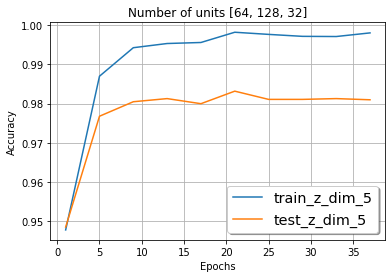

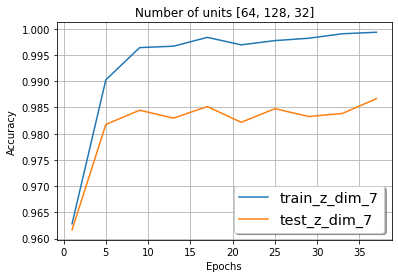

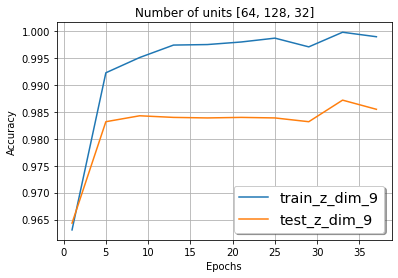

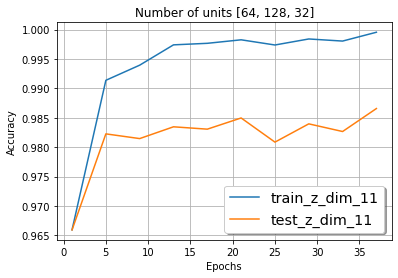

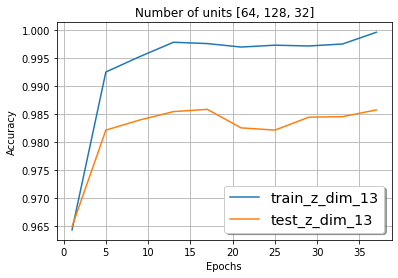

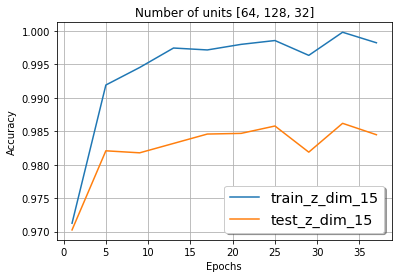

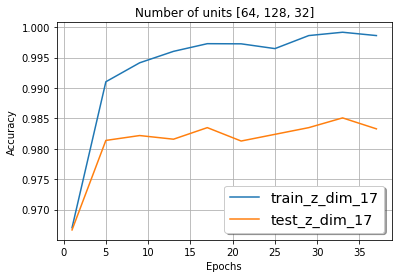

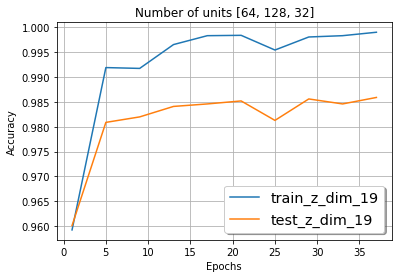

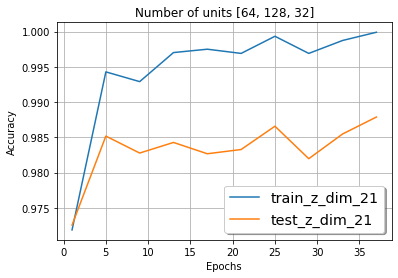

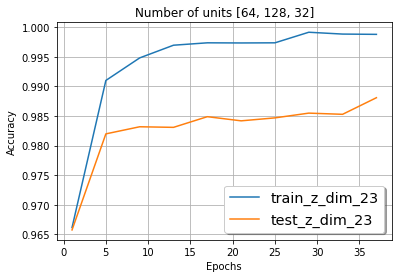

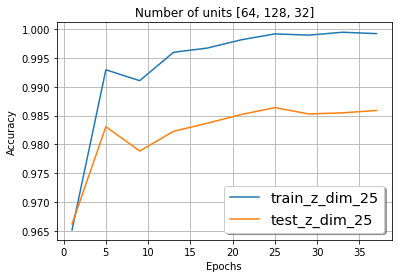

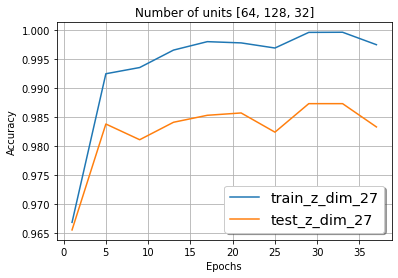

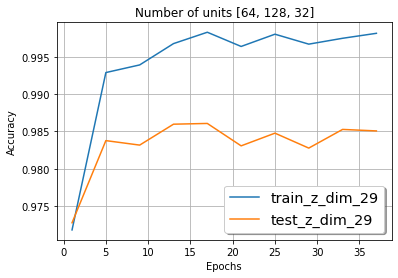

<Figure size 432x288 with 0 Axes>

In [13]:
num_units = [64,128,32]
batch_size = 128
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_128_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experi

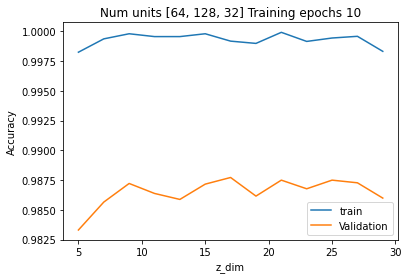

In [14]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


# num_units = [64,64,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_30_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv


AttributeError: ignored

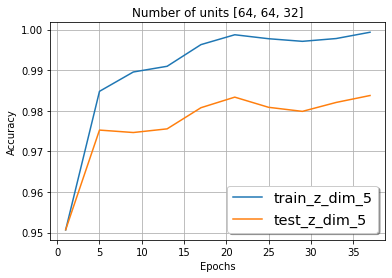

<Figure size 432x288 with 0 Axes>

In [17]:
num_units = [64,64,32]
batch_size = 128
for z_dim in z_dim_range:
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

## Plot z_dim Vs Accuracy

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2

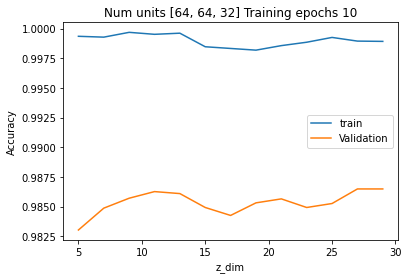

In [18]:
num_units=[64,64,32]
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


# num_units=[8,8,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_

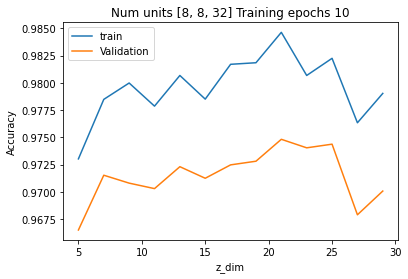

In [19]:
z_dim_range = [5, 30, 2]
num_epochs = 10
num_units=[8,8,32]
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


# Num Units [8,8,4]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_e

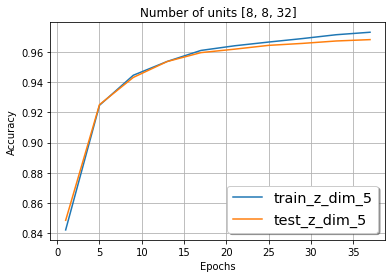

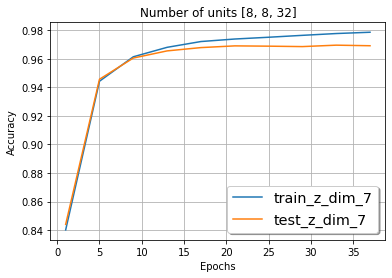

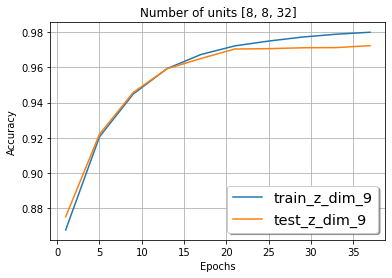

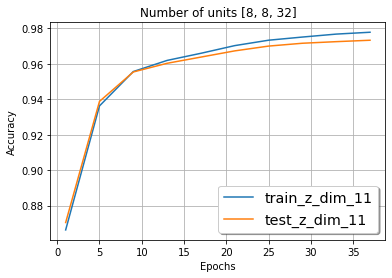

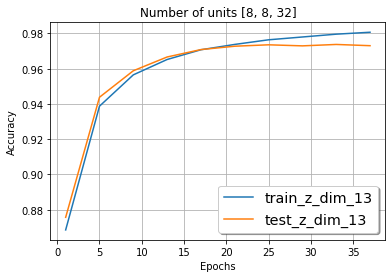

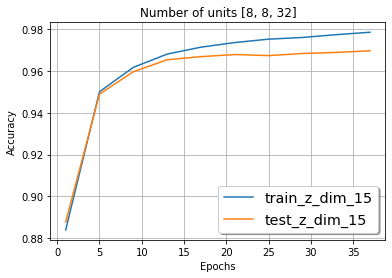

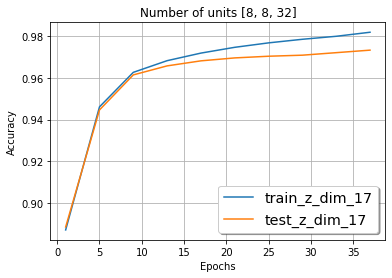

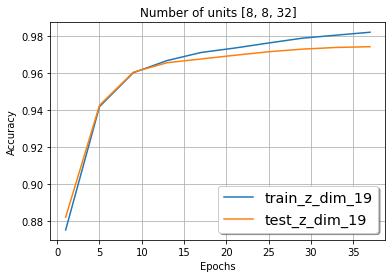

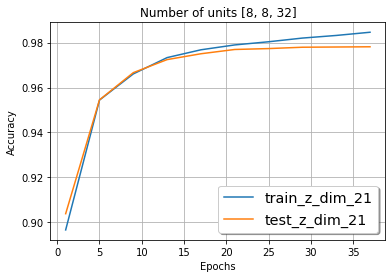

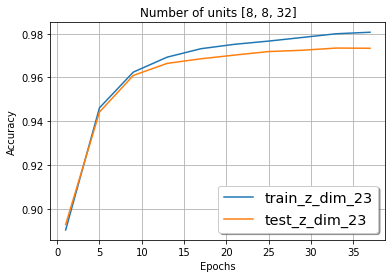

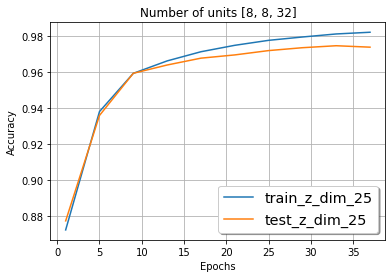

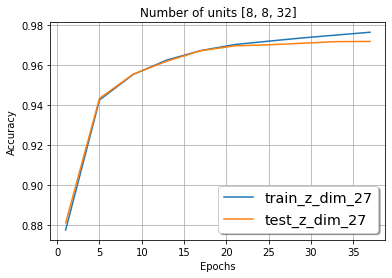

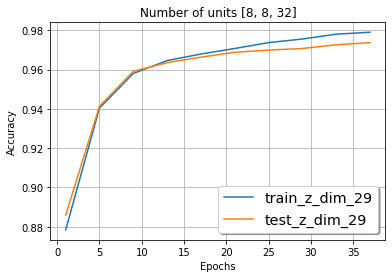

<Figure size 432x288 with 0 Axes>

In [20]:
num_units = [8, 8, 32]
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_

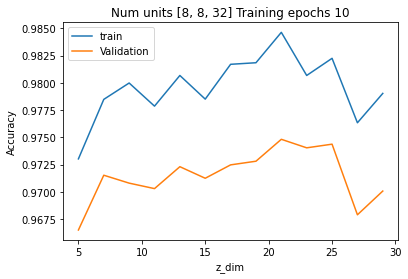

In [21]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                num_val_samples=num_val_samples,
                )


# Num units [4, 8, 2]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_9_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_9_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_9_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_e

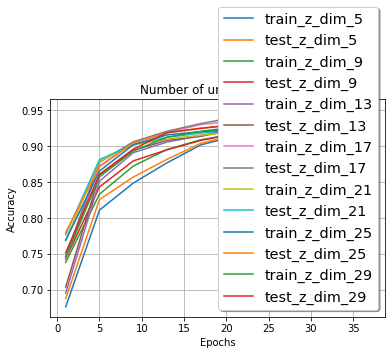

In [22]:
num_units = [4, 4, 32]
for z_dim in range(5, 30, 4):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_4_4_

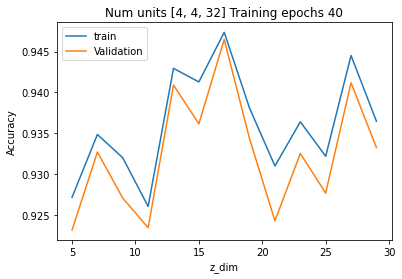

In [23]:
z_dim_range = [5, 30, 2]
num_epochs = 40
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                num_val_samples=num_val_samples,
                )

# Scatter plot 

Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_10_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_10_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_64_64_10_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4) 0.9852764423076924
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_lea

{4: [[36, 0.9433092948717948]],
 8: [[40, 0.9769631410256412], [36, 0.8845152243589743]],
 16: [[48, 0.9766626602564102]],
 32: [[64, 0.9839743589743588], [48, 0.9795673076923076]],
 64: [[96, 0.9852764423076924], [64, 0.9832732371794872]]}

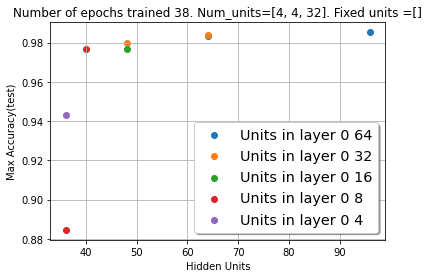

In [24]:
num_units = [[64, 128, 32],
                  [64, 64, 32],
                  [64, 32, 32],
                  [32, 32, 32],
                  [32, 16, 32],
                  [16, 16, 32],
                  [8, 8, 32],
                  [8, 4, 32],
                  [4, 4, 32],
                  ][1:]
z_dim = 10
plot_hidden_units_accuracy_layerwise(root_path=root_path,
                        experiment_name=experiment_name,
                        num_units=num_units,
                        num_cluster_config=num_cluster_config,
                        z_dim=z_dim,
                        run_id=run_id,
                        activation_output_layer="LINEAR",
                        dataset_name=dataset_name,
                        split_name=split_name,
                        batch_size=batch_size,
                        num_val_samples=num_val_samples,
                        num_decoder_layer=5,
                        layer_num=0,
                        fixed_layers=[],
                        dataset_types=["test"]
                      )

Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_16_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_16_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_16_16_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4) 0.9762620192307692
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learni

{4: [[36, 0.9288862179487181]],
 8: [[40, 0.9681490384615384], [36, 0.9456129807692308]],
 16: [[48, 0.9762620192307692], [40, 0.9698517628205128]]}

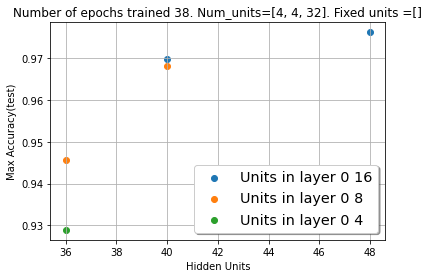

In [25]:
z_dim = 5
num_units = [
             [16, 16, 32],
             [16, 8, 32],
             [8,8,32],
             [8, 4, 32],
             [4, 4, 32]
             ]
plot_hidden_units_accuracy_layerwise(root_path=root_path,
                        experiment_name=experiment_name,
                        num_units=num_units,
                        num_cluster_config=num_cluster_config,
                        z_dim=z_dim,
                        run_id=run_id,
                        activation_output_layer="LINEAR",
                        dataset_name=dataset_name,
                        split_name=split_name,
                        batch_size=batch_size,
                        num_val_samples=num_val_samples,
                        num_decoder_layer=5,
                        layer_num=0,
                        fixed_layers=[],
                        dataset_types=["test"]
                      )

Skipping num_units [16, 16, 32]
Skipping num_units [16, 8, 32]
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_32_8_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4) 0.9681490384615384
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive

{4: [[32, 0.9456129807692308]], 8: [[32, 0.9681490384615384]]}

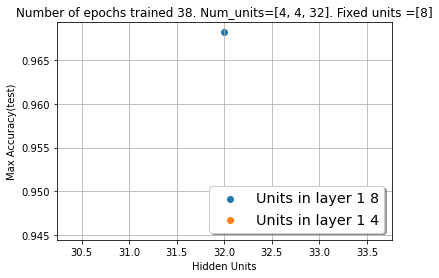

In [26]:
z_dim = 5
num_units = [
             [16, 16, 32],
             [16, 8, 32],
             [8,8,32],
             [8, 4, 32],
             [4, 4, 32]
             ]
plot_hidden_units_accuracy_layerwise(root_path=root_path,
                        experiment_name=experiment_name,
                        num_units=num_units,
                        num_cluster_config=num_cluster_config,
                        z_dim=z_dim,
                        run_id=run_id,
                        activation_output_layer="LINEAR",
                        dataset_name=dataset_name,
                        split_name=split_name,
                        batch_size=batch_size,
                        num_val_samples=num_val_samples,
                        num_decoder_layer=5,
                        layer_num=1,
                        fixed_layers=[8],
                        dataset_types=["test"]
                      )

# 2 layer Architectures

## num_units = [64,32]

In [27]:
num_units_list = [[64, 32],
                  [32, 32],
                  [16, 32],
                  [8, 32],
                  [4, 32],
                  [2, 32],
                      ]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_lear

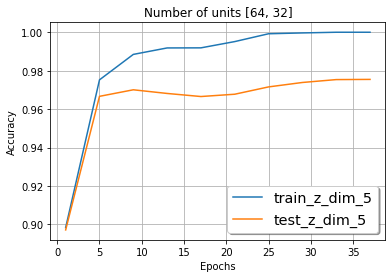

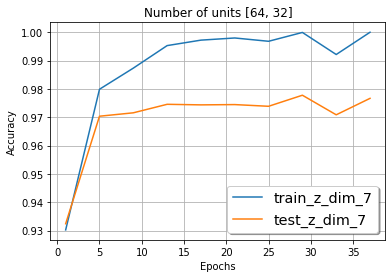

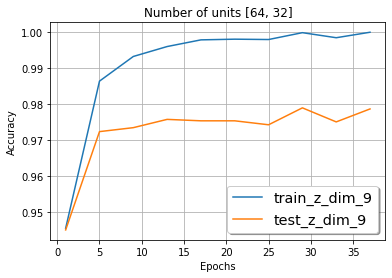

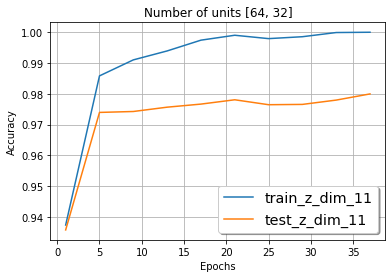

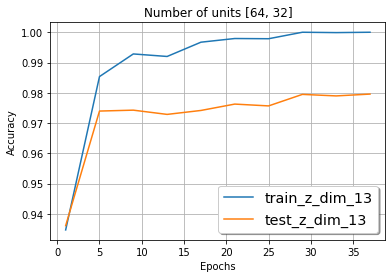

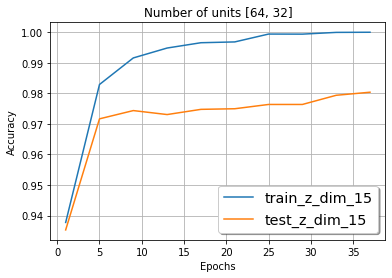

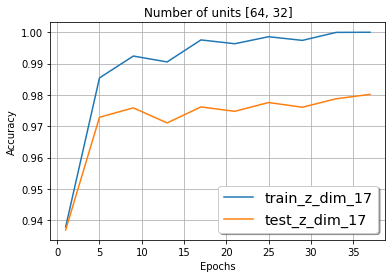

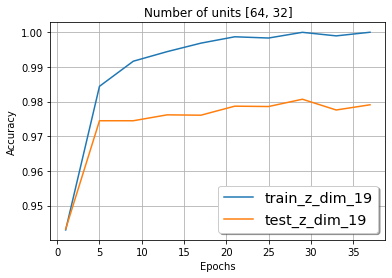

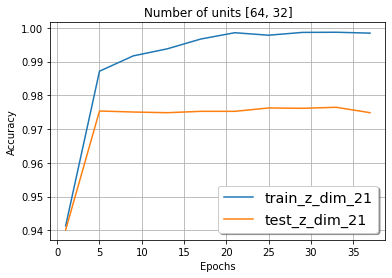

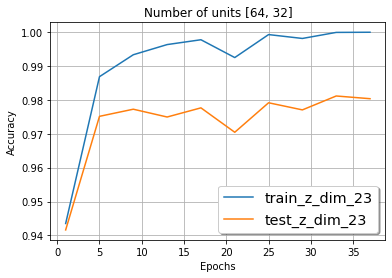

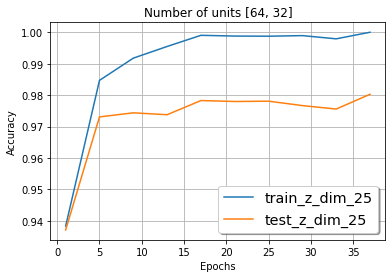

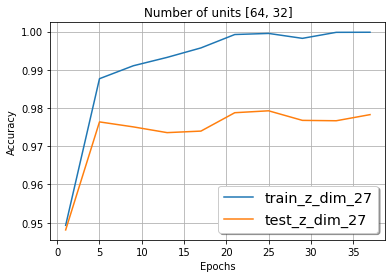

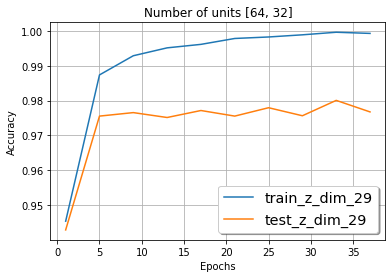

<Figure size 432x288 with 0 Axes>

In [28]:
num_units = num_units_list[0]
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0

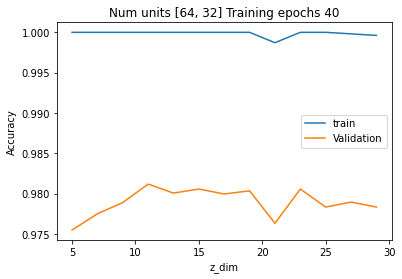

In [29]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                num_val_samples=num_val_samples,
                )


## num_units = [32,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_lear

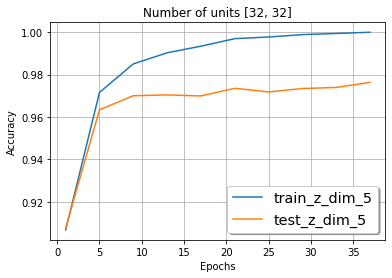

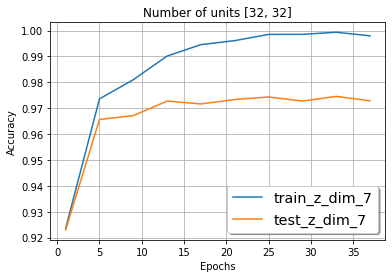

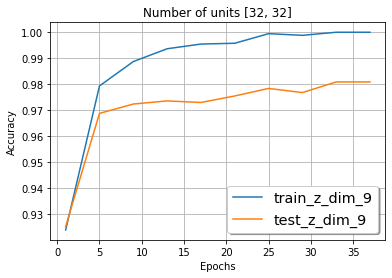

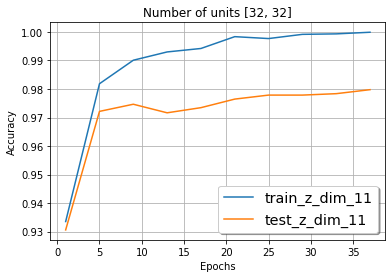

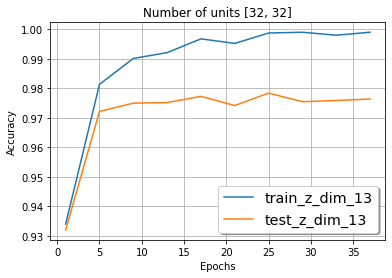

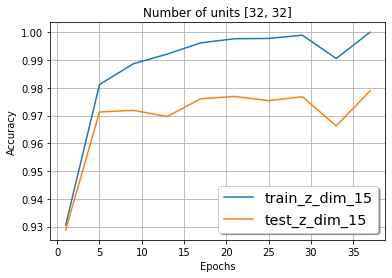

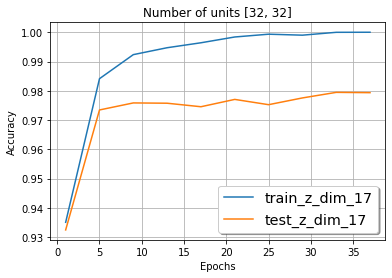

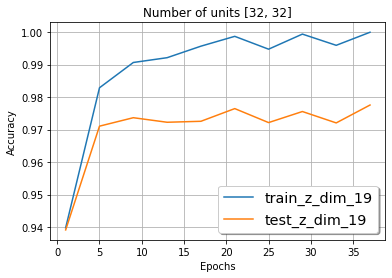

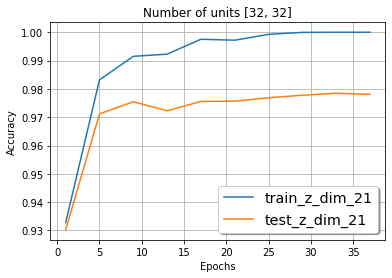

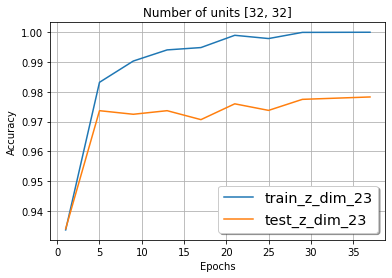

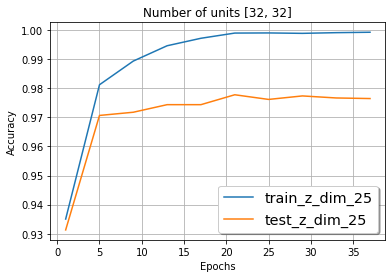

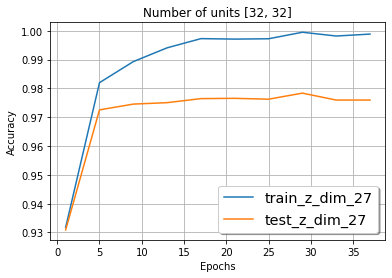

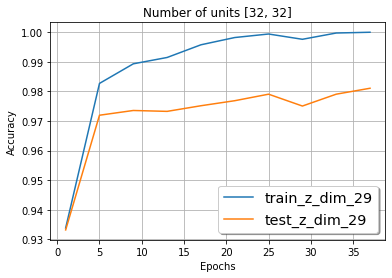

<Figure size 432x288 with 0 Axes>

In [30]:
num_units = num_units_list[1]
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0

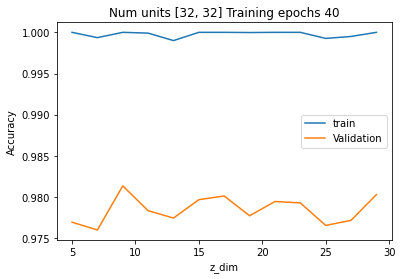

In [31]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


## num_units = [16,32]


[16, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/con

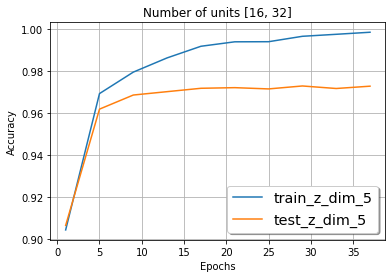

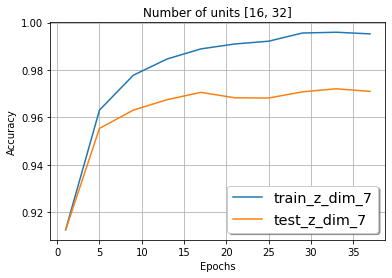

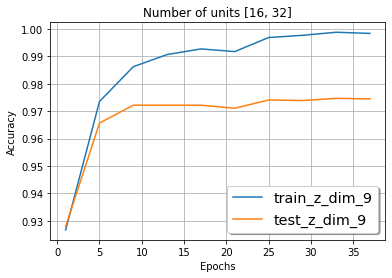

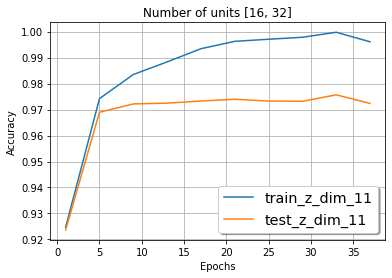

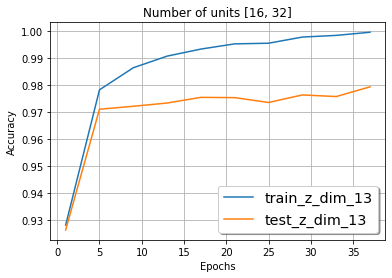

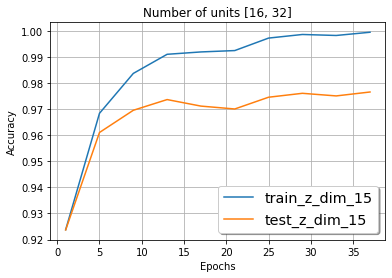

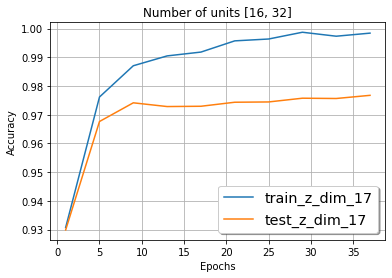

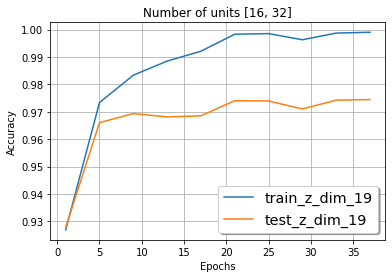

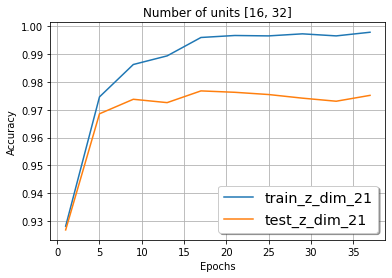

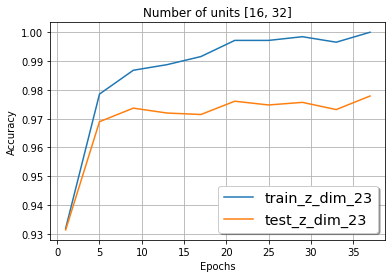

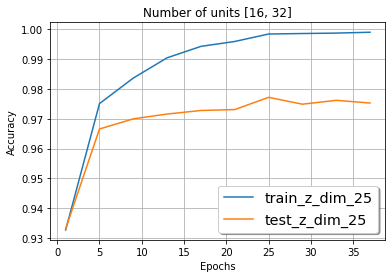

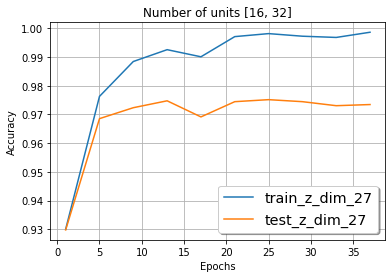

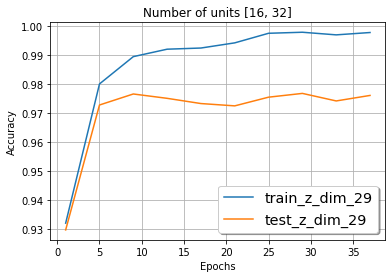

<Figure size 432x288 with 0 Axes>

In [32]:
num_units = num_units_list[2]
print(num_units)
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0

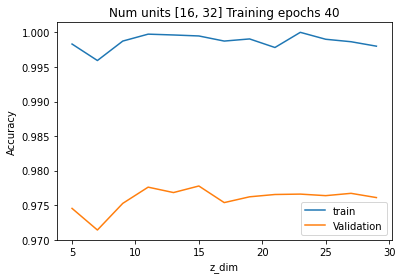

In [33]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                num_val_samples=num_val_samples,
                )


## num_units = [8,32]

[8, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_le

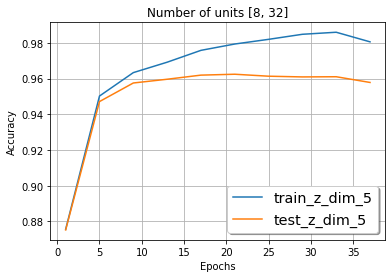

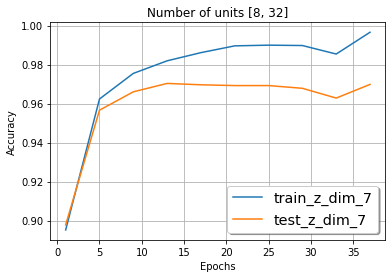

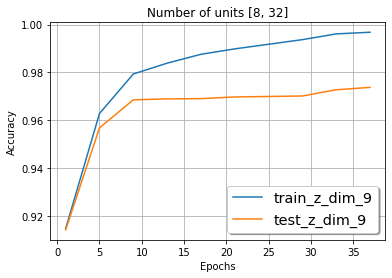

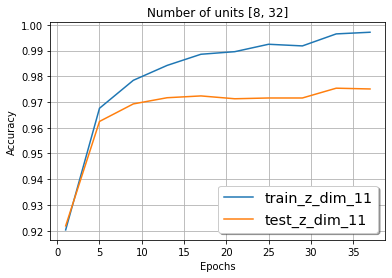

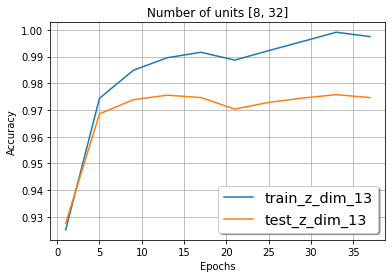

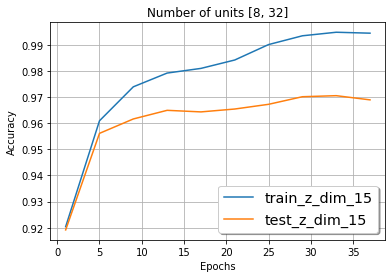

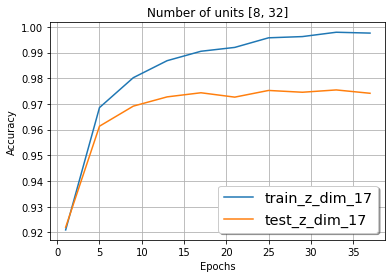

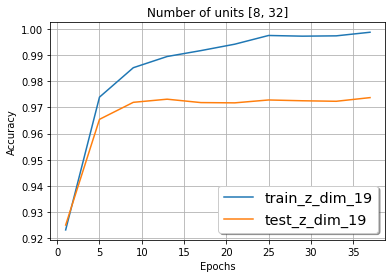

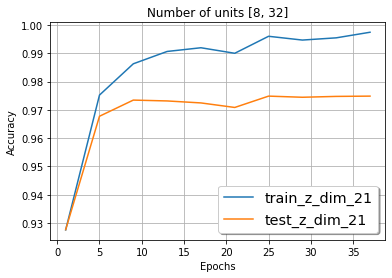

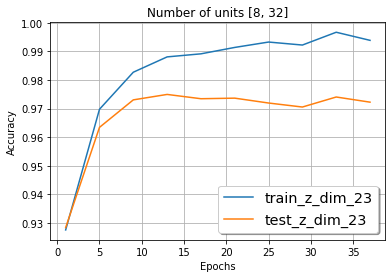

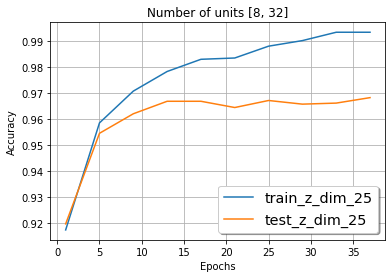

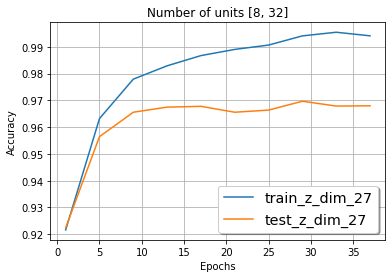

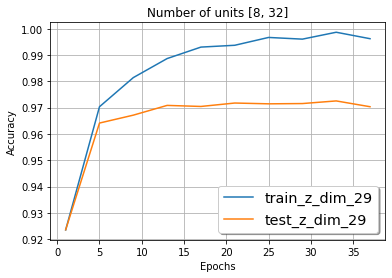

<Figure size 432x288 with 0 Axes>

In [34]:
num_units = num_units_list[3]
print(num_units)
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_

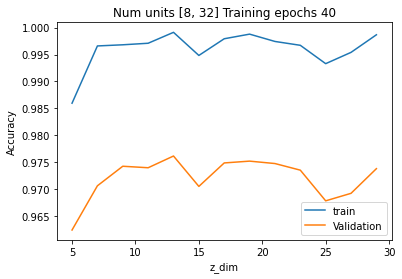

In [35]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


## num_units = [4,32]


[4, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_le

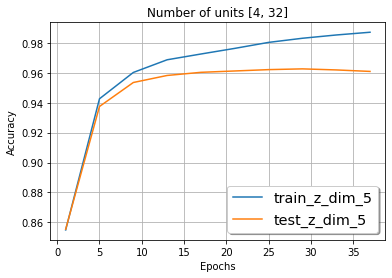

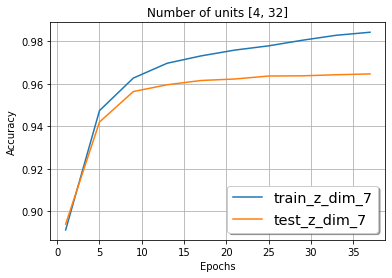

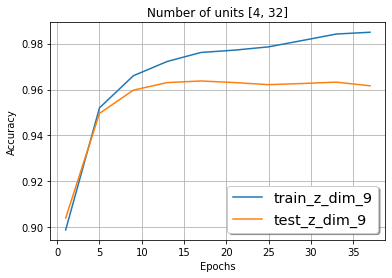

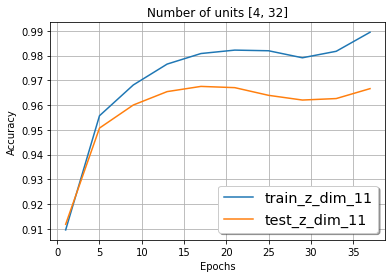

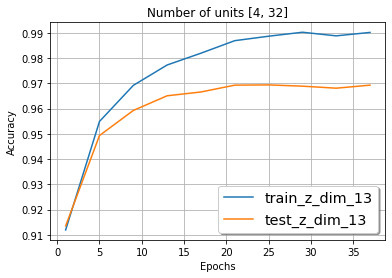

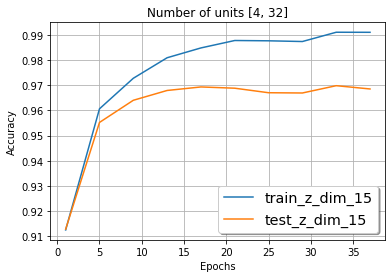

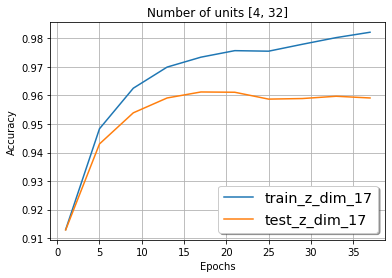

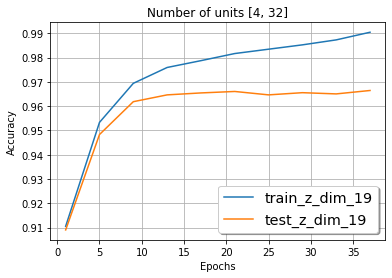

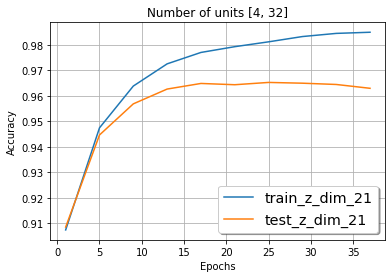

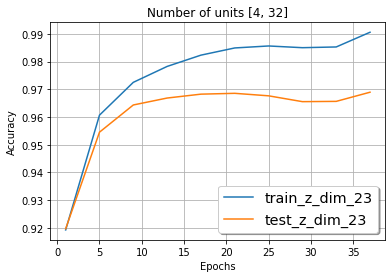

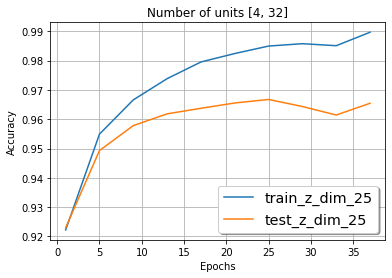

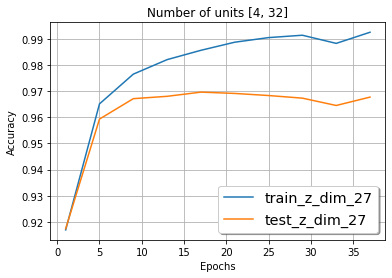

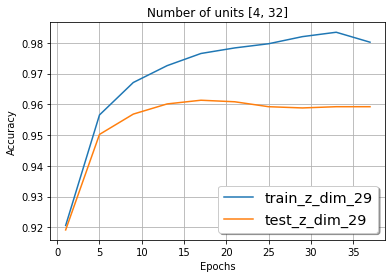

<Figure size 432x288 with 0 Axes>

In [36]:
num_units = num_units_list[4]
print(num_units)
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_

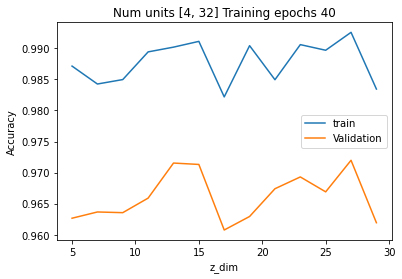

In [37]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


## num_units = [2,32]


[2, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_le

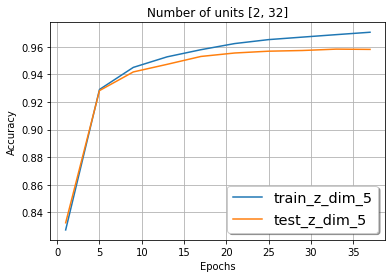

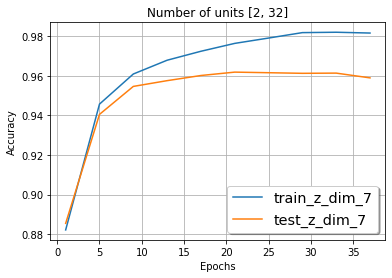

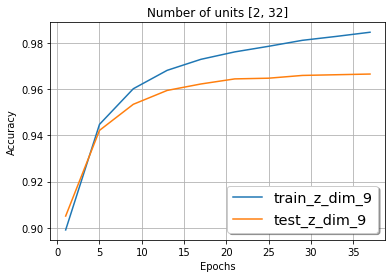

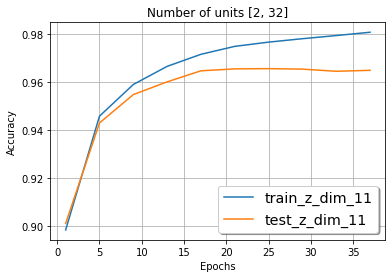

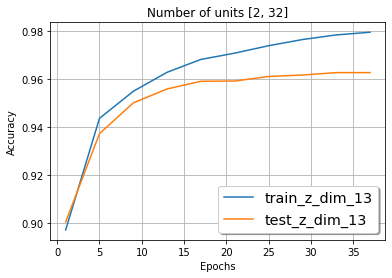

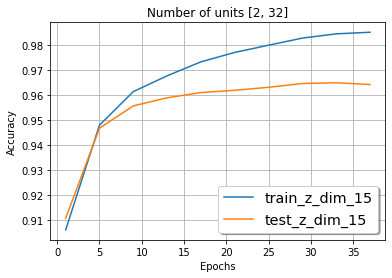

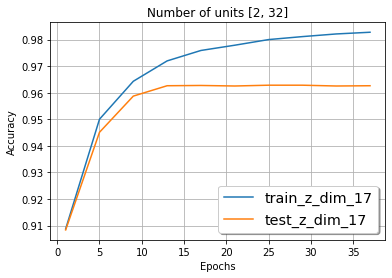

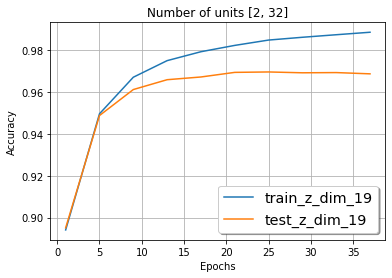

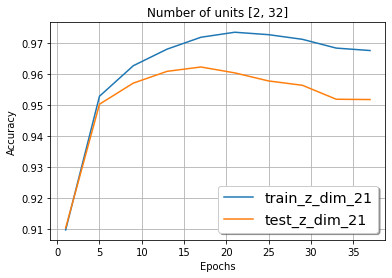

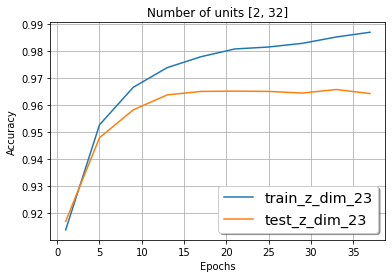

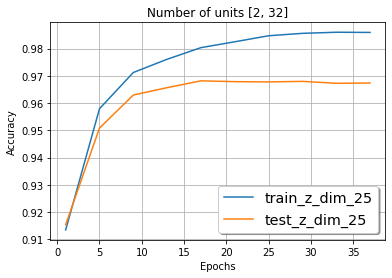

<Figure size 432x288 with 0 Axes>

In [38]:
num_units = num_units_list[5]
print(num_units)
for z_dim in range(5, 27, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_

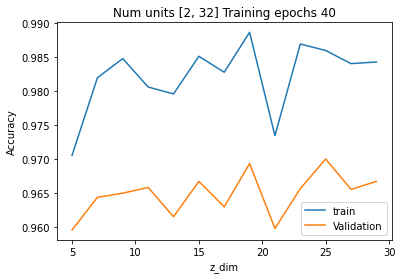

In [39]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


In [31]:
!rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1


In [47]:
!rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1


## Scatter plot

Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4) 0.9784655448717948
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learni

{2: [[32, 0.9601362179487181]],
 4: [[32, 0.9725560897435898]],
 8: [[32, 0.9754607371794872]],
 16: [[32, 0.9770633012820512]],
 32: [[32, 0.9778645833333334]],
 64: [[32, 0.9784655448717948]]}

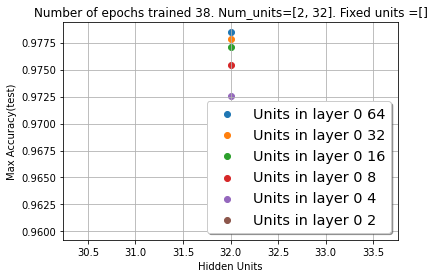

In [54]:
z_dim = 10
plot_hidden_units_accuracy_layerwise(root_path=root_path,
                        experiment_name=experiment_name,
                        num_units=num_units_list,
                        num_cluster_config=num_cluster_config,
                        z_dim=z_dim,
                        run_id=run_id,
                        activation_output_layer="LINEAR",
                        dataset_name=dataset_name,
                        split_name=split_name,
                        batch_size=batch_size,
                        num_val_samples=num_val_samples,
                        num_decoder_layer=5,
                        layer_num=0,
                        fixed_layers=[],
                        dataset_types=["test"]
                      )